In [1]:
from lib_fetaure_analysis import Features
from defect_analysis import Test
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import torch as Torch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

In [9]:
pathCartellaTresh = Path('/home/gabro/GrapheDetectProject/cartellaTrash')
pathCartellaContours = Path('/home/gabro/GrapheDetectProject/contours')
shapes = Features.from_thresh_to_contours_print_features(pathCartellaTresh,pathCartellaContours)
for shape in shapes:
    print("Shape features:")
    for key in shape:
        print(key, ' : ', shape[key])
    print()

df = pd.DataFrame.from_records(shapes)
df.to_csv('/home/gabro/GrapheDetectProject/box_dataframe.csv')
print(df)
df2 = df.drop(df.columns[0],axis=1) #droppo la prima colonna che rappresenta i nomi (stringhe)
print(df2)
df2.to_csv('/home/gabro/GrapheDetectProject/no_name_dataframe.csv')


Shape features:
nome_imm  :  graphene_122634
area_px  :  1458.0
num_pixels  :  3021
perimeter_px  :  186.0493106842041
circularity  :  0.5293114118788803
solidity  :  121.5
compactness  :  0.007858648810422949
feret_diameter  :  0.9422460341087125
eccentricity  :  0.5645045142899838

Shape features:
nome_imm  :  graphene_231617
area_px  :  558.0
num_pixels  :  1216
perimeter_px  :  107.38857507705688
circularity  :  0.6080340539095493
solidity  :  37.2
compactness  :  0.016996065095442905
feret_diameter  :  0.8748915979733232
eccentricity  :  0.574959598839383

Shape features:
nome_imm  :  graphene_122634
area_px  :  1444.5
num_pixels  :  2592
perimeter_px  :  198.08448791503906
circularity  :  0.46262220691271566
solidity  :  160.5
compactness  :  0.010479688909551357
feret_diameter  :  1.0410183167468616
eccentricity  :  0.5846012598048931

Shape features:
nome_imm  :  graphene_301236
area_px  :  55.0
num_pixels  :  224
perimeter_px  :  33.82591128349304
circularity  :  0.60405090944

In [18]:
pathCartellaTresh = Path('/home/gabro/GrapheDetectProject/cartellaTrash')
pathCartellaContours = Path('/home/gabro/GrapheDetectProject/contours')
shapes = Features.from_thresh_to_contours_print_features(pathCartellaTresh,pathCartellaContours)
# for shape in shapes:
#     print("Shape features:")
#     for key in shape:
#         print(key, ' : ', shape[key])
#     print()

df = pd.DataFrame.from_records(shapes)
df.to_csv('/home/gabro/GrapheDetectProject/box_dataframe.csv')
print("old df")
print(df)

# raggruppa le righe in base al nome dell'immagine e calcola la somma dell'area e del perimetro, e la media pesata per l'area degli altri parametri
groupedDf = df.groupby('nome_imm').apply(lambda x: pd.Series({
    'area_px': x['area_px'].sum(),  #somma semplice per area e perimetro 
    'num_pixels': x['num_pixels'].sum(),
    'perimeter_px': x['perimeter_px'].sum(),
    'circularity': (x['circularity'] * x['area_px']).sum() / x['area_px'].sum(),    #somma pesata per l'area per tutti gli altri 
    'solidity': (x['solidity'] * x['area_px']).sum() / x['area_px'].sum(),
    'compactness': (x['compactness'] * x['area_px']).sum() / x['area_px'].sum(),
    'feret_diameter': (x['feret_diameter'] * x['area_px']).sum() / x['area_px'].sum(),
    'eccentricity': (x['eccentricity'] * x['area_px']).sum() / x['area_px'].sum(),
}))

groupedDf.to_csv('/home/gabro/GrapheDetectProject/groupedDataframe.csv')
print("-----------------------------------------------------------------------------")
print("grouped dataframe")
print(groupedDf)

#aggiungo total_energy 


# groupedDf.drop(columns=['nome_imm'])
# print(groupedDf)

# no_name_groupedDf = groupedDf.drop(['nome_imm'], axis=1) #droppo la prima colonna che rappresenta i nomi (stringhe)
# df.drop(['B', 'C'], axis=1)
# print("noname dataframe")
# print(no_name_groupedDf)
# no_name_groupedDf.to_csv('/home/gabro/GrapheDetectProject/no_name_dataframe.csv')

old df
          nome_imm  area_px  num_pixels  perimeter_px  circularity   
0  graphene_122634   1458.0        3021    186.049311     0.529311  \
1  graphene_231617    558.0        1216    107.388575     0.608034   
2  graphene_122634   1444.5        2592    198.084488     0.462622   
3  graphene_301236     55.0         224     33.825911     0.604051   
4  graphene_227444    258.0         720     64.407339     0.781554   
5  graphene_227444    105.5         324     46.500943     0.613111   
6  graphene_176095    709.5        1482    108.976000     0.750759   
7  graphene_312780    578.0        1122    100.661613     0.716820   
8  graphene_176095     42.0         196     25.142182     0.834936   

     solidity  compactness  feret_diameter  eccentricity  
0  121.500000     0.007859        0.942246      0.564505  
1   37.200000     0.016996        0.874892      0.574960  
2  160.500000     0.010480        1.041018      0.584601  
3    7.857143     0.092873        0.856103      0.844071

<Axes: >

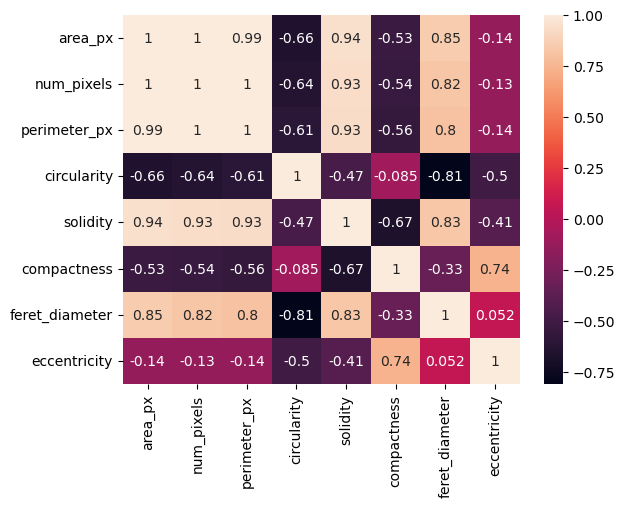

In [19]:
corr = groupedDf.corr()
sns.heatmap(corr, annot=True)

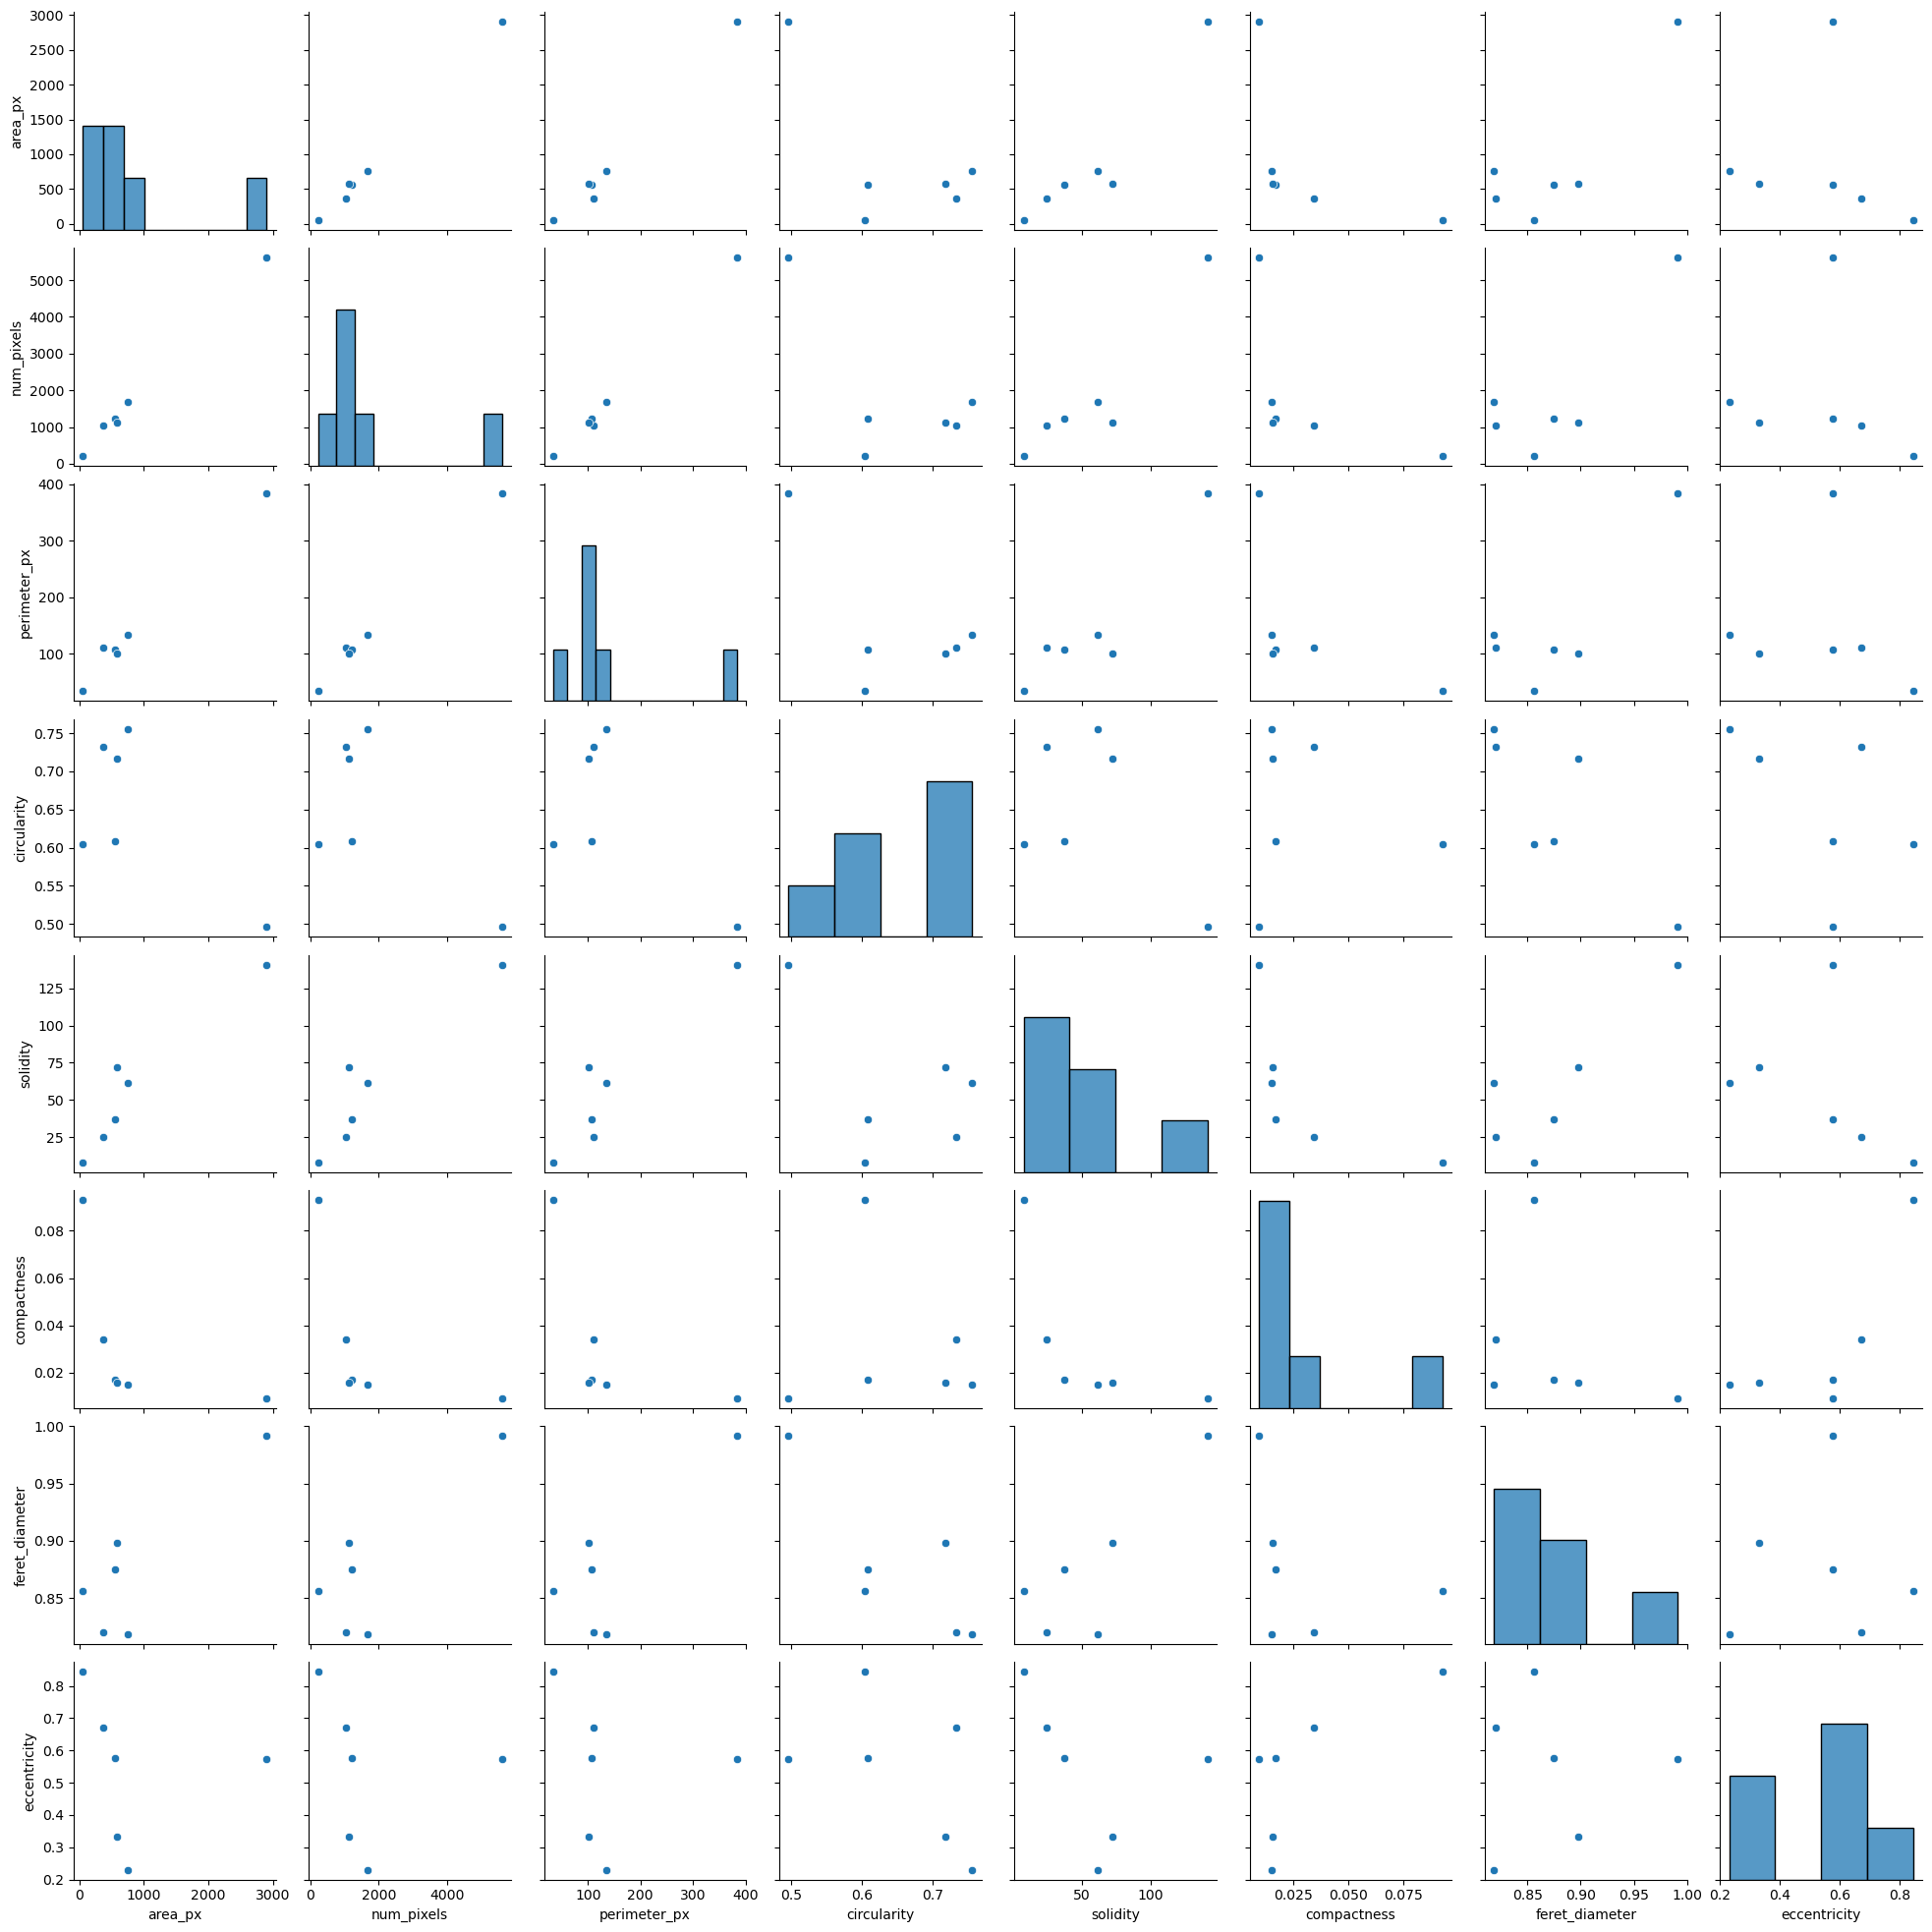

In [20]:
# # load data set
# df = sns.load_dataset('iris')

# Basic correlogram
sns.pairplot(groupedDf)
plt.show()

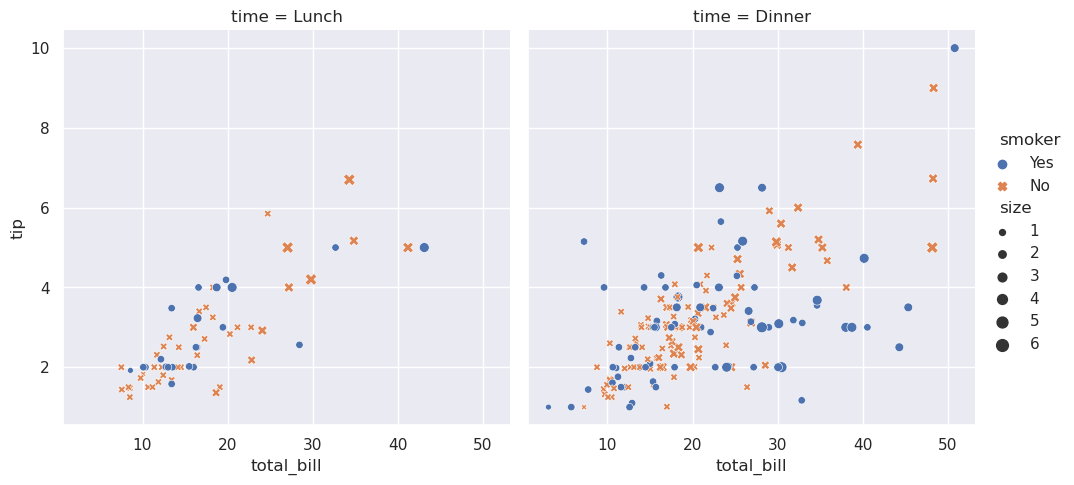

In [3]:
# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

# plt.show(sns)